# Image Segmentation

Image segmentation, using a modified [U-Net].

## What is Image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of the object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image -- this task is known as **segmentation**. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satallite imaging, just to name a few.

We use the [Oxford-IIIT Pet Dataset] ([Parkhi et al, 2012]). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories.

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

[U-Net]: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
[Oxford-IIIT Pet Dataset]: https://www.robots.ox.ac.uk/%7Evgg/data/pets/
[Parkhi et al, 2012]: https://www.robots.ox.ac.uk/%7Evgg/publications/2012/parkhi12a/parkhi12a.pdf

In [1]:
# Copyright 2022 Victor I. Afolabi
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install tensorflow-datasets

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

/Users/victor/dev/tutorials/tf-playground/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(f'Using TensorFlow version: {tf.__version__}')

Using TensorFlow version: 2.9.2


## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

### Load the data

In [5]:
dataset, info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    data_dir='../../ tudata/',
    with_info=True
)

2022-09-18 15:11:35.001951: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "INVALID_ARGUMENT: Error executing an HTTP request: HTTP response code 400 with body '{"error":"invalid_grant","error_description":"Invalid JWT Signature."}'". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                                                                                                            | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                                                                                                            | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                                                                                                                                                | 0/18 [00:04<?, ? MiB/s]

Dl Size...:   0%|                                                                                                                                                               | 0/773 [00:04<?, ? MiB/s]

Extraction completed...: 0 file [00:04

Dataset oxford_iiit_pet downloaded and prepared to ../data/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1


In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are: {0, 1, 2}.

In [6]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL = 128, 128, 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

EPOCHS, LEARNING_RATE = 20, 1e-3
OUTPUT_CLASSES, VAL_SUBSPLITS = 3, 5

BATCH_SIZE, BUFFER_SIZE = 64, 1000

TRAIN_LENGTH = info.splits['train'].num_examples
VAL_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

### Normalize the data

In [7]:
def normalize(
    input_image: tf.TensorArray,
    input_mask: tf.TensorArray
) -> tuple[tf.TensorArray, tf.TensorArray]:
    """Normalize image & image mask.
    
    Arguments:
        input_image (tf.TensorArray): Input image in range [0, 255].
        input_mask (tf.TensorArray): Input mask in range [1, 3].
    
    Returns:
        tuple[tf.TensorArray, tf.TensorArray]:
            Normalized image in range [0, 1] and normalized image
            mask in range [0, 2].
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    
    return input_image, input_mask


def load_image(datapoint: dict[str, tf.Tensor]) -> tuple[tf.TensorArray, tf.TensorArray]:
    """Resize and normalize image and image mask.
    
    Arguments:
        datapoint (dict): Each image data.
    
    Returns:
        tuple[tf.TensorArray, tf.TensorArray]:
            Resized & normalized image & image mask.
    """
    input_image = tf.image.resize(datapoint['image'], IMG_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMG_SIZE)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [8]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
train_images, test_images

(<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>)

### Augment the data

In [11]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed: int = 42) -> None:
        super().__init__()

        # Both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
    
    def call(
        self,
        inputs: tf.TensorArray,
        labels: tf.TensorArray,
    ) -> tuple[tf.TensorArray, tf.TensorArray]:

        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)

        return inputs, labels

In [12]:
# Create train & test mini-batches.
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

### Visualize the data

In [13]:
def display(display_lists: list[tf.TensorArray]) -> None:
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    n_display = len(display_lists)

    for i, display_list in enumerate(display_lists):
        plt.subplot(1, n_display, i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list))
        plt.axis('off')

    plt.show()

2022-09-18 15:21:17.668050: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-18 15:21:17.672050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


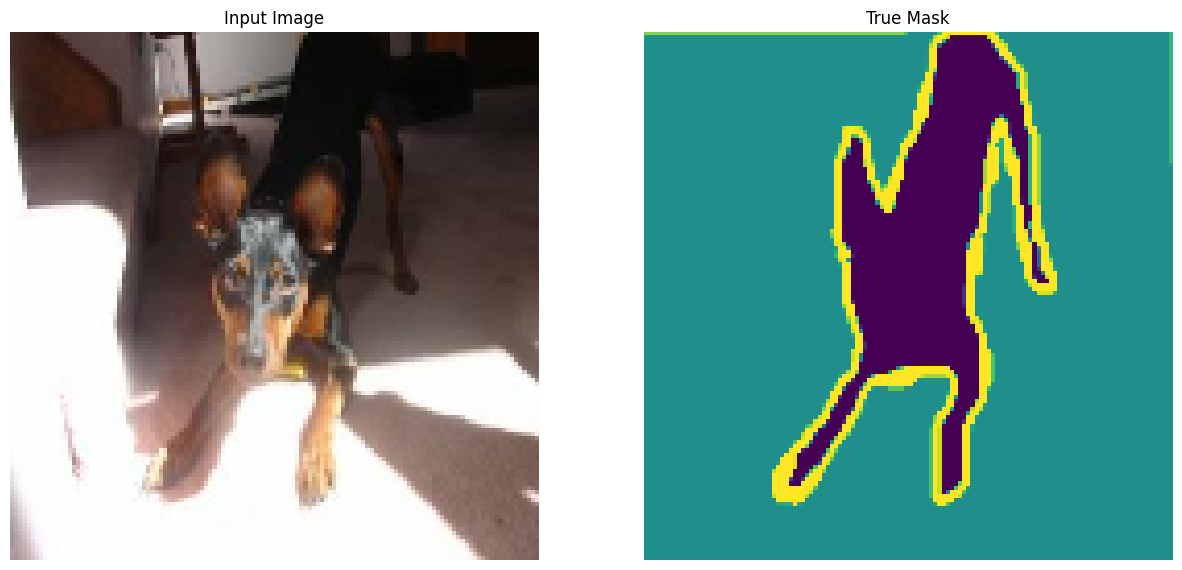

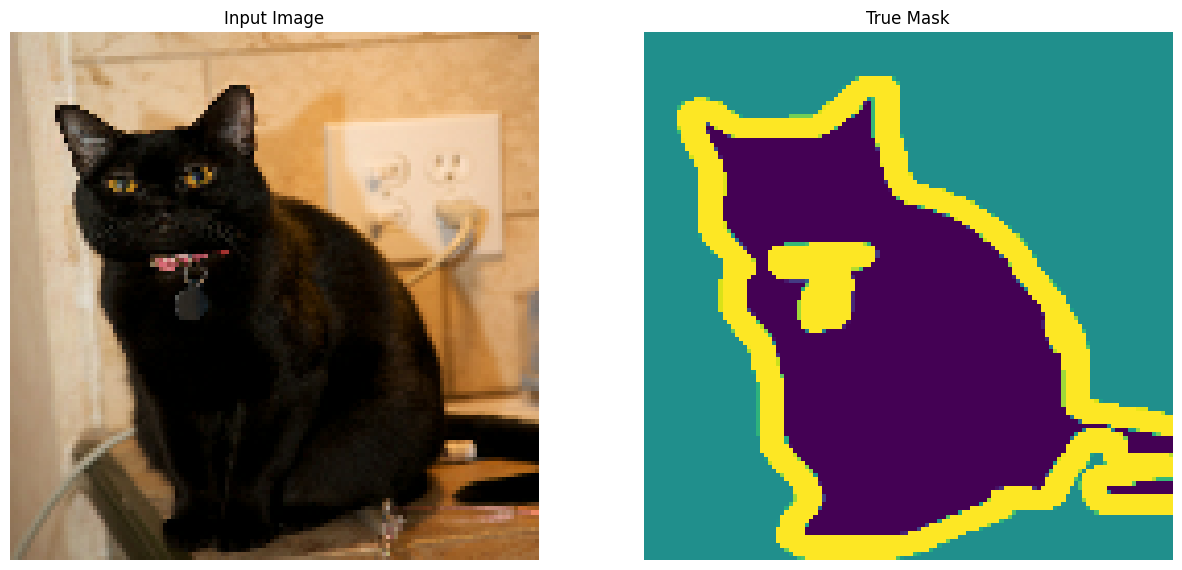

2022-09-18 15:21:18.780425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Define the model

The model being used here is a modified [U-Net]. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, we use a pretrained model -- [MobileNetV2] --as the encoder. For the decoder, we will use the upsample block, which is already implemented in the [pix2pix] example in TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditinoal GAN](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

[U-Net]: https://arxiv.org/abs/1505.04597
[MobileNetV2]: https://arxiv.org/abs/1801.04381
[pix2pix]: https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(
        self,
        input_shape: tuple[int, int, int] = IMG_SHAPE,
    ) -> None:
        super(Encoder, self).__init__()

        model = tf.keras.applications.MobileNetV2(
            input_shape=input_shape, include_top=False,
        )
        
        # Use the activations of these layers.
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]

        model_output = [model.get_layer(name).output
                        for name in layer_names]
        
        self.encoder_model = tf.keras.Model(inputs=model.input,
                                            outputs=model_output)
        self.encoder_model.trainable = False
    
    def call(
        self, x: tf.TensorArray, training: bool = False
    ) -> tf.TensorArray:
        return self.encoder_model(x)


class UNet(tf.keras.Model):
    def __init__(
        self, input_shape: tuple[int, int, int] = IMG_SHAPE,
        output_channels: int = OUTPUT_CLASSES,
        dropout: float = 0.5,
    ) -> None:
        super(UNet, self).__init__()
        self.encoder = Encoder(input_shape=input_shape)

        # Don't train the encoder.
        self.encoder.trainable = False
        initializer = tf.random_normal_initializer(0., 0.02)
        
        # The deocoder.
        self.upscale_layers = [
            tf.keras.layers.Conv2DTranspose(
                512, 3, strides=2, padding='same',
                kernel_initializer=initializer,
            ),  # 4x4 -> 8x8
            tf.keras.layers.Conv2DTranspose(
                256, 3, strides=2, padding='same',
                kernel_initializer=initializer,
            ),  # 8x8 -> 16x16
            tf.keras.layers.Conv2DTranspose(
                128, 3, strides=2, padding='same',
                kernel_initializer=initializer,
            ),  # 16x16 -> 32x32
            tf.keras.layers.Conv2DTranspose(
                64, 3, strides=2, padding='same',
                kernel_initializer=initializer,
            ),  # 32x32 -> 64x64
        ]
        
        self.batch_norm = tf.keras.layers.BatchNormalizer()
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.activation = tf.keras.layers.ReLU()
        self.concat = tf.keras.layers.Concatenate()
        
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3,
            strides=2, padding='same',
        )
    
    def call(
        self, inputs: tf.TensorArray, training: bool = False
    ) -> tf.TensorArray:
        # Downsamping.
        skips = self.encoder(inputs)
        x = skips[-1]
        # Skip connections.
        skips = reversed(skips[:-1])
        
        # Upsampling and establishing skip connections.
        for layer, skip in zip(self.upscale_layers, skips):
            x = layer(x)
            x = self.batch_norm(x, training=training)
            x = self.dropout(x, training=training)
            x = self.activation(x)
            
            # Concatenate output with skip connections.
            x = self.concat([x, skip])

        # This is the last layer of the model.
        output = self.output_layer(x)
        return output

In [15]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL),
    include_top=False
)

# Use the activations of these layers.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output
                      for name in layer_names]

# Create the feature extraction model.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4   => 8x8
    pix2pix.upsample(256, 3),  # 8x8   => 16x16
    pix2pix.upsample(128, 3),  # 16x16 => 32x32
    pix2pix.upsample(64, 3),   # 32x32 => 64x64
]

In [17]:
def unet_model(output_channels: int) -> tf.keras.Model:
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL])
    
    # Downsampling through the model.
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsamping and establishing the skip connections.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # This is the last layer of the model.
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same'
    )  # 64x64 => 128x128

    outputs = last(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

### Create & compile model

In [18]:
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Visualize model

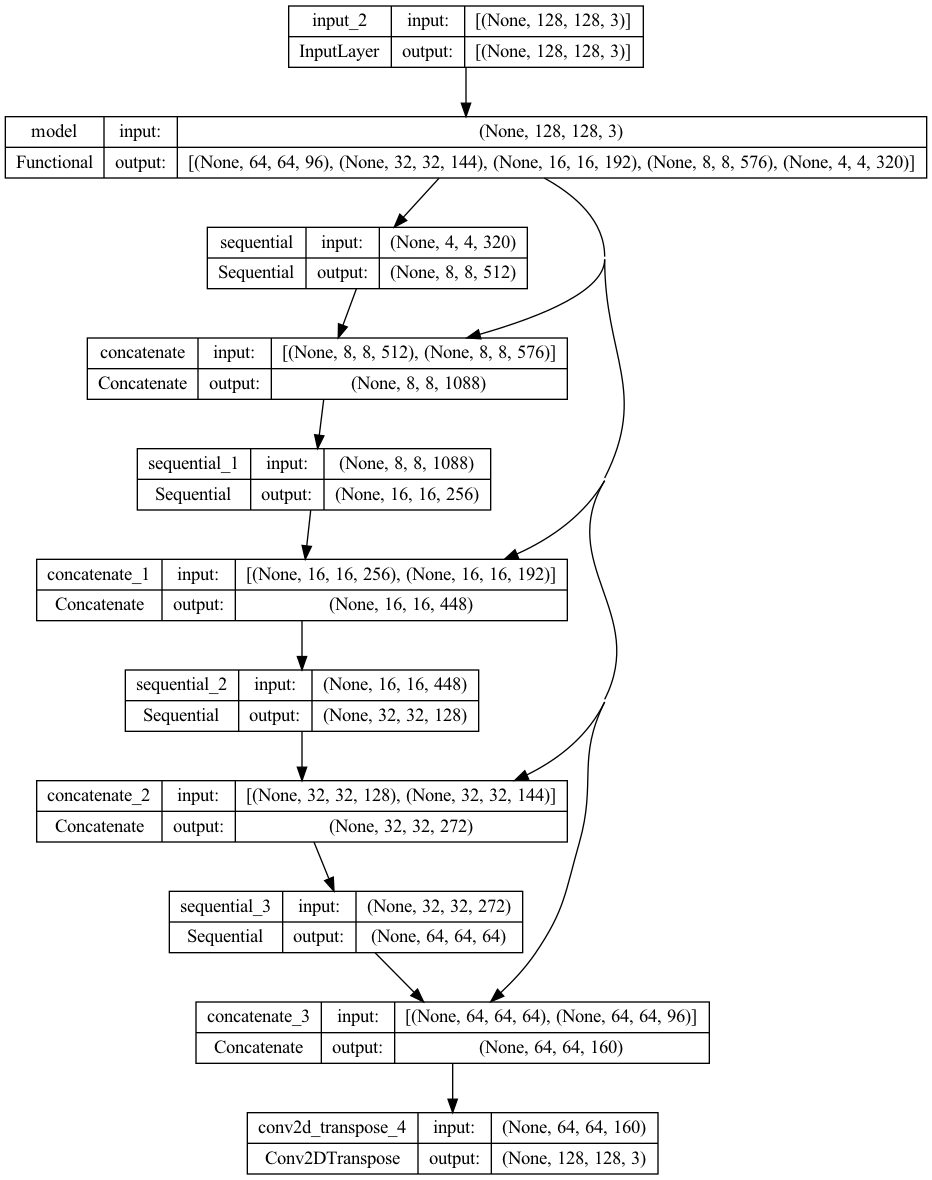

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [21]:
def create_mask(pred_mask: tf.TensorArray) -> tf.TensorArray:
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]


def show_predictions(dataset: tf.data.Dataset | None = None, num: int = 1) -> None:
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2022-09-15 03:11:37.531864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 478ms/step


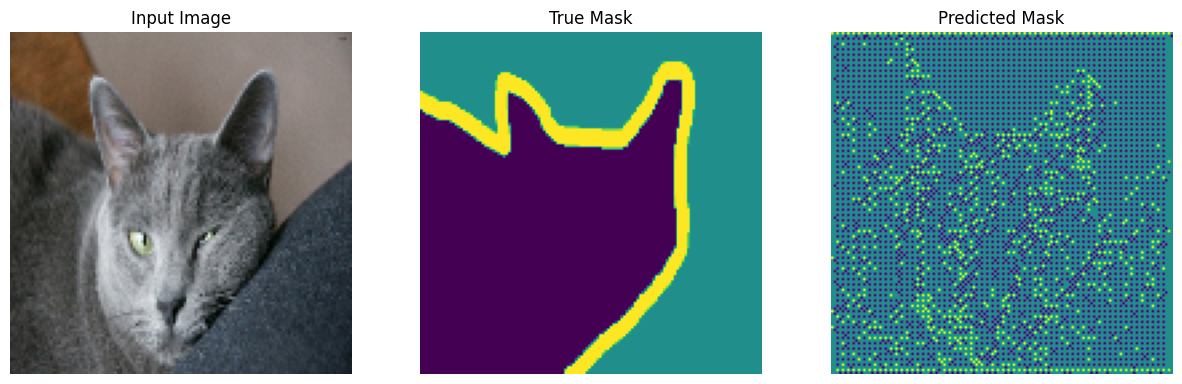

In [22]:
show_predictions()

### Train model

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch: int, logs: dict | None = None) -> None:
        clear_output(wait=True)
        show_predictions()
        print(f'\nSample prediction after {epoch+1} epoch(s)\n')

1/1 [==============================] - 0s 30ms/step


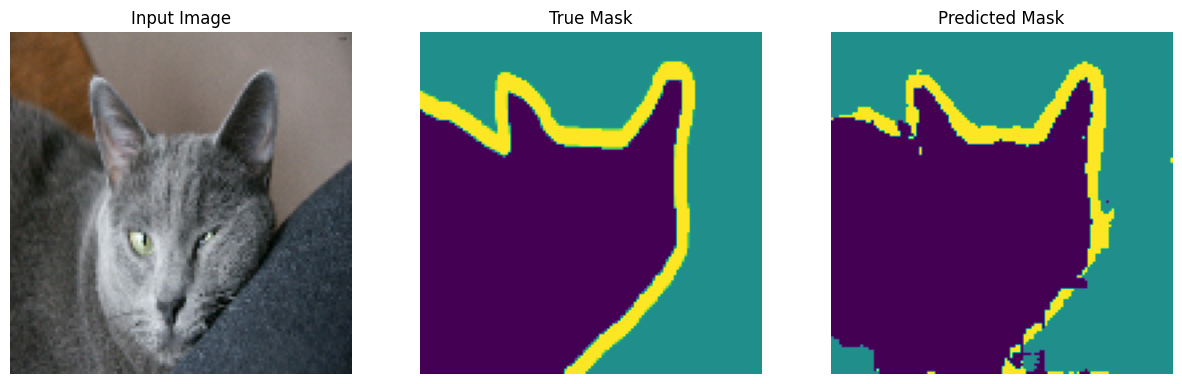


Sample prediction after 20 epoch(s)

57/57 [==============================] - 30s 536ms/step - loss: 0.1832 - accuracy: 0.9192 - val_loss: 0.2694 - val_accuracy: 0.8973


In [24]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()],
)

### Visualize training history

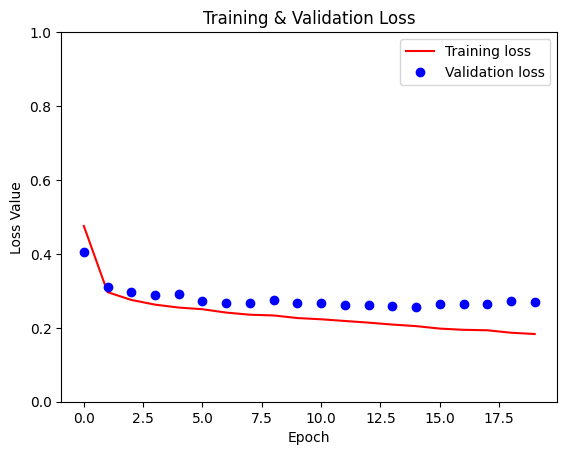

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.title('Training & Validation Loss')

plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])

plt.legend()
plt.show()

In [29]:
# Convert to TFLite for on-device inference.

# import os

TF_LITE_MODEL_PATH = '../saved_models/image-segmentation.tflite'
# os.makedirs(TF_LITE_MODEL_PATH, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(TF_LITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpgtiscawz/assets


INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpgtiscawz/assets
2022-09-15 03:36:26.026020: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-15 03:36:26.026043: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-15 03:36:26.027184: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpgtiscawz
2022-09-15 03:36:26.046511: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-09-15 03:36:26.046527: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpgtiscawz
2022-09-15 03:36:26.099673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-15 03:36:26.110945: I tensorflow/cc/saved_model/load

## Make predictions

2/2 [==============================] - 0s 159ms/step


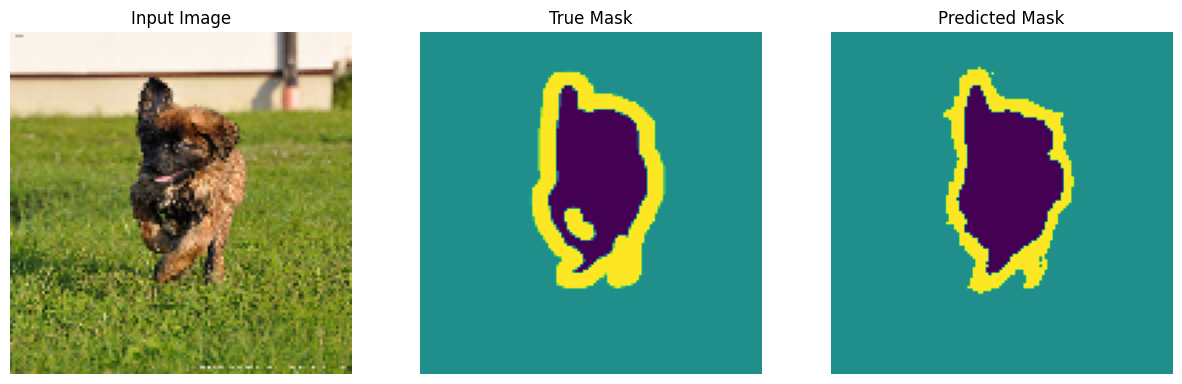

2/2 [==============================] - 0s 140ms/step


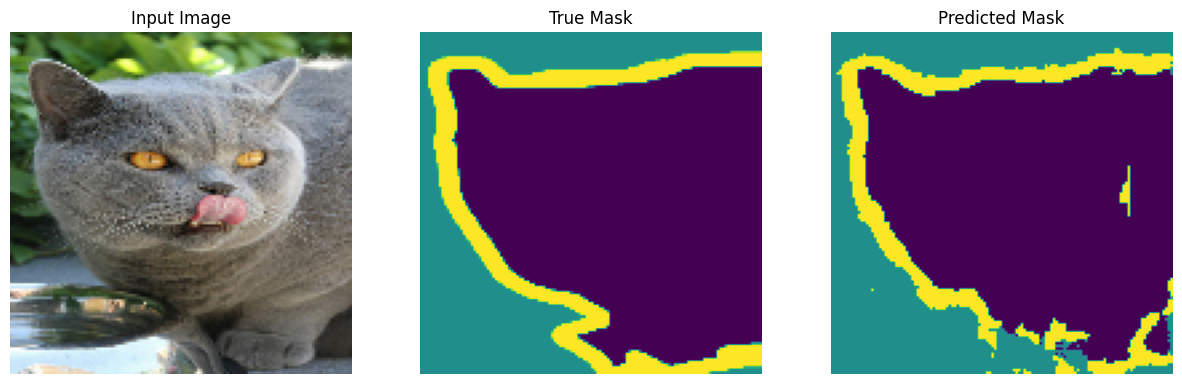

2/2 [==============================] - 0s 149ms/step


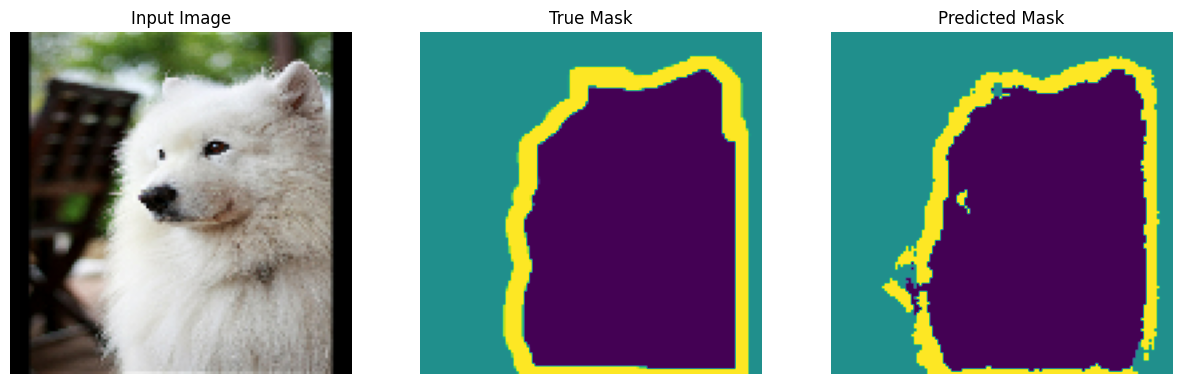

In [28]:
show_predictions(test_batches, num=3)

## Optional: Imbalanced classes & class weight

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since sementation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weigghing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to [Classification onimbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) to learn more.

To [avoid ambiguity], [`Model.fit`] does not support `class_weight` argument for inputs with 3+ dimensions.

[avoid ambiguity]: https://github.com/keras-team/keras/issues/3653#issuecomment-243939748
[`Model.fit`]: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [30]:
try:
    history = model.fit(
        train_batches, epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        class_weight={0: 2.0, 1: 2.0, 2: 1.0},
    )
    assert False
except Exception as e:
    print(f'Expected {type(e).__name__}: {e}')

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


So, in this case you need to implement the weighting yourself. You'll do this using sample weights; In addition to `(data, label)` pairs, [`Model.fit`] also accepts `(data, label, sample_weight)` triples.

Keras [`Model.fit`] propagates the `sample_weight` to the losses and metrics, which also accepts a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

[`Model.fit`]: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [31]:
label = [0, 0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.NONE
)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make samle weights, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple. Where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [32]:
def add_sample_weights(
    image: tf.TensorArray,
    label: tf.TensorArray
) -> tuple[tf.TensorArray, tf.TensorArray, tf.TensorArray]:
    """Add sample weight.
    
    Arguments:
        image (tf.TensorArray): Images.
        label (tf.TensorArray): Labels.
    
    Returns:
        tuple[tf.TensorArray, tf.TensorArray, tf.TensorArray]:
            Corresponding to (image, label, sample_weight)
    """
    # The weight for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights /= tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label
    # at each pixel as an index into the `class_weights`.
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [33]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [34]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

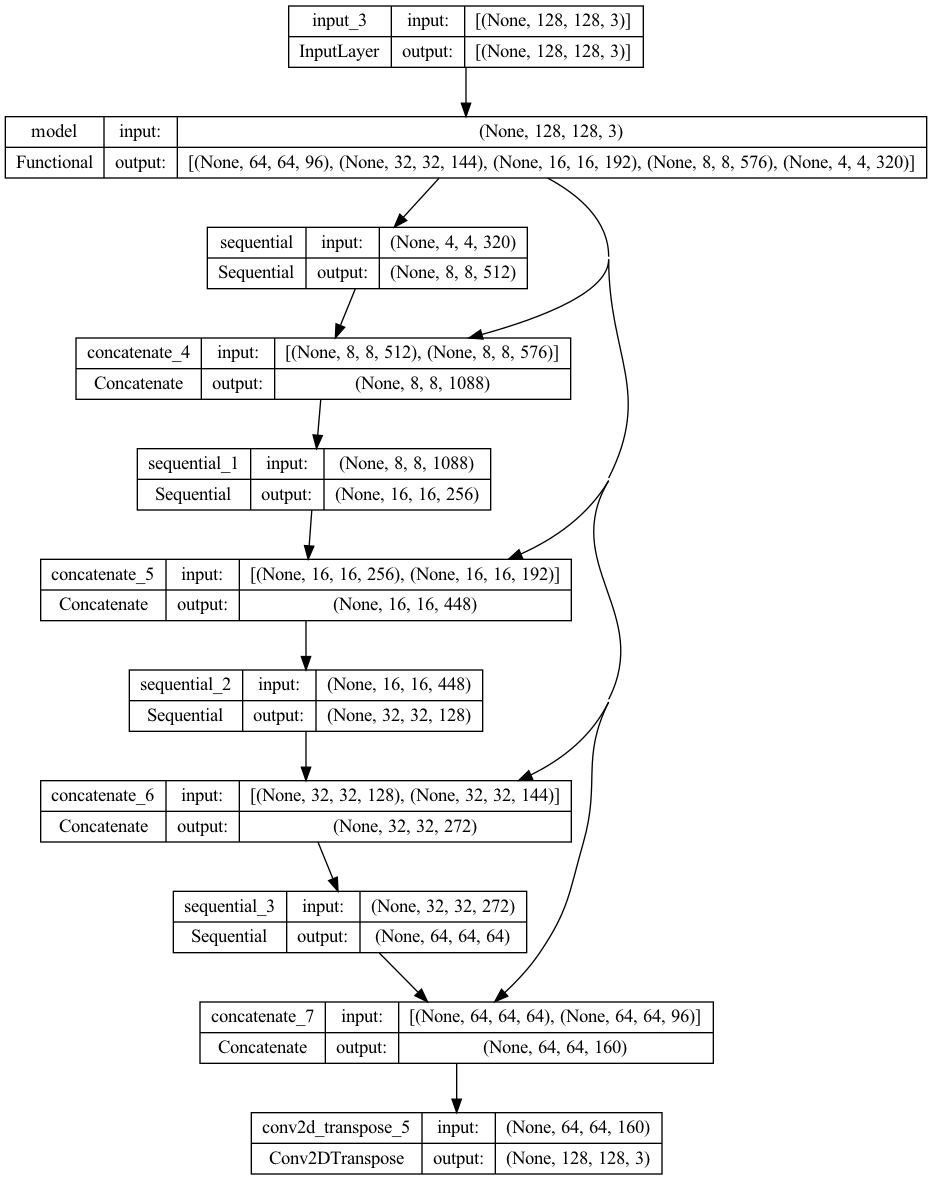

In [35]:
tf.keras.utils.plot_model(weighted_model, show_shapes=True)

In [36]:
weighted_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_3[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

1/1 [==============================] - 0s 26ms/step


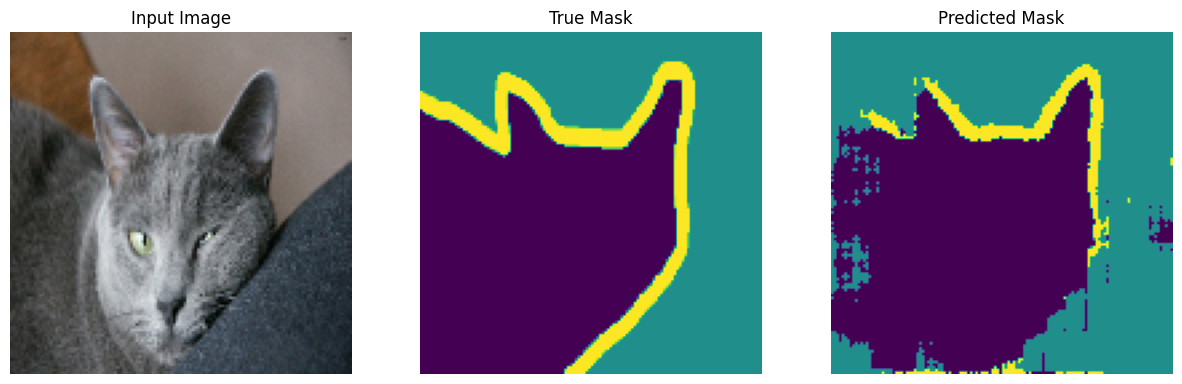


Sample prediction after 7 epoch(s)

57/57 [==============================] - 31s 538ms/step - loss: 0.1559 - accuracy: 0.7921 - val_loss: 0.1218 - val_accuracy: 0.8255
Epoch 8/20
11/57 [====>.........................] - ETA: 20s - loss: 0.1534 - accuracy: 0.7914

In [ ]:
# Train weighted model.
weighted_history = weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=test_batches.map(add_sample_weights),
    callbacks=[DisplayCallback()],
)

In [ ]:
weighted_loss = weighted_history.history['loss']
weighted_val_loss = weighted_history.history['val_loss']

plt.figure()
plt.title('Weighted Training & Validation Loss')

plt.plot(weighted_history.epoch, weighted_loss, 'r', label='Training loss')
plt.plot(weighted_history.epoch, weighted_val_loss, 'bo', label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])

plt.legend()
plt.show()

## Convert to TF Lite Model

In [ ]:
# import os

TF_LITE_MODEL_PATH = '../saved_models/image-segmentation-weighted.tflite'
# os.makedirs(TF_LITE_MODEL_PATH, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(weighted_model)
tflite_model = converter.convert()

with open(TF_LITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_PATH)
print(interpreter.get_signature_list())

In [ ]:
# img_path = ''
# img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
# img_arr = tf.keras.utils.img_to_array(img)
# img_arr = tf.expand_dims(img_arr, 0)  # create batch.

In [ ]:
# segment_lite = interpreter.get_signature_runner('serving_default')
# pred_mask = segment_lite(input=image)